Saving Predictive_Analysis_Final.xlsx to Predictive_Analysis_Final.xlsx
Training data shape: (2332, 48)
Test data shape: (98, 48)
Number of features: 46

📊 Improved Forecast Summary Table:
            Actual (INR)  Forecast (INR)        Error  Absolute % Error
ds                                                                     
2025-01-01   67371641.87      46686896.0  20684745.87             30.70
2025-02-01   47946026.67      40034024.0   7912002.67             16.50
2025-03-01   48072077.17      47491488.0    580589.17              1.21
2025-04-01   43608233.67      32763560.0  10844673.67             24.87
2025-05-01   48876790.27      39504932.0   9371858.27             19.17


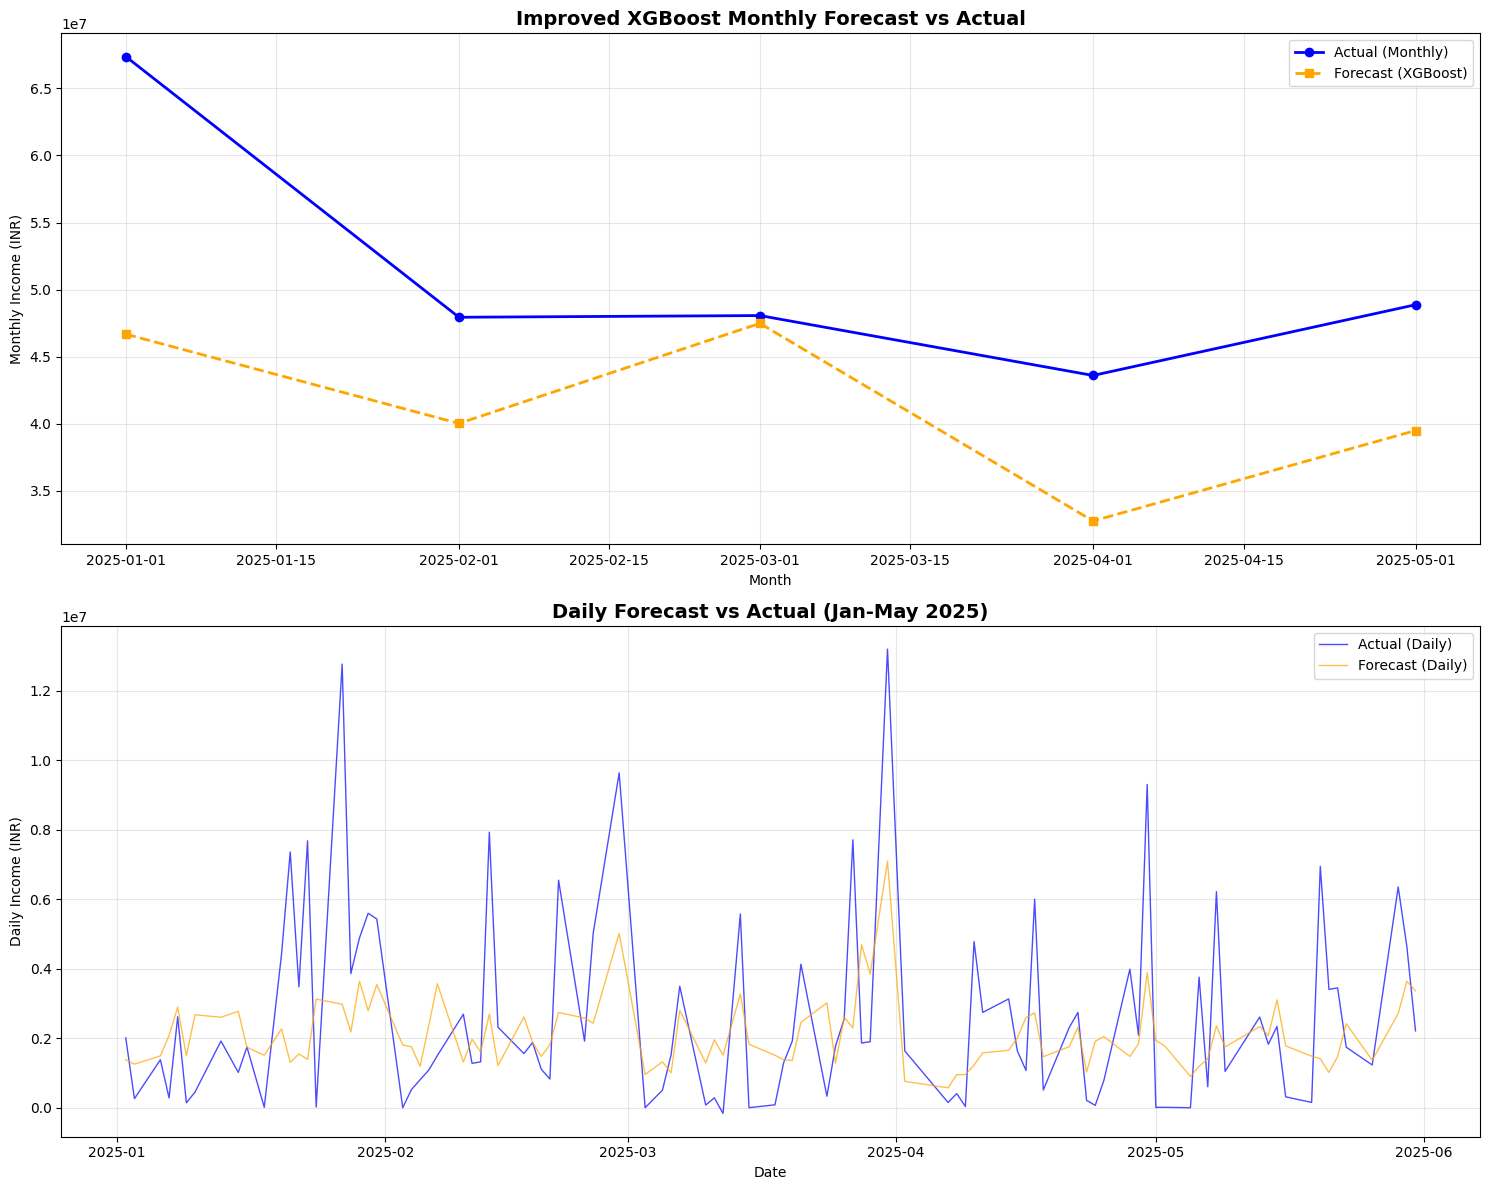


📅 Daily Forecast Table (Jan to May 2025):
      Date  Actual (INR)  Forecast (INR)  Error (%)
2025-01-02    2008500.00    1380288.7500     -31.28
2025-01-03     259600.00    1254341.5000     383.18
2025-01-06    1381058.40    1492832.0000       8.09
2025-01-07     281024.00    2079644.6250     640.02
2025-01-08    2619125.50    2897232.7500      10.62
2025-01-09     139425.50    1490404.1250     968.96
2025-01-10     450000.00    2676408.2500     494.76
2025-01-13    1918700.00    2604207.5000      35.73
2025-01-15    1017000.00    2776234.0000     172.98
2025-01-16    1748600.00    1738557.2500      -0.57
2025-01-18      10343.70    1508949.2500   14488.10
2025-01-20    4432246.54    2270288.7500     -48.78
2025-01-21    7364000.00    1305826.8750     -82.27
2025-01-22    3480361.81    1547813.7500     -55.53
2025-01-23    7684605.10    1391583.2500     -81.89
2025-01-24      18800.00    3128165.5000   16539.18
2025-01-27   12775232.24    2978767.7500     -76.68
2025-01-28    3862400

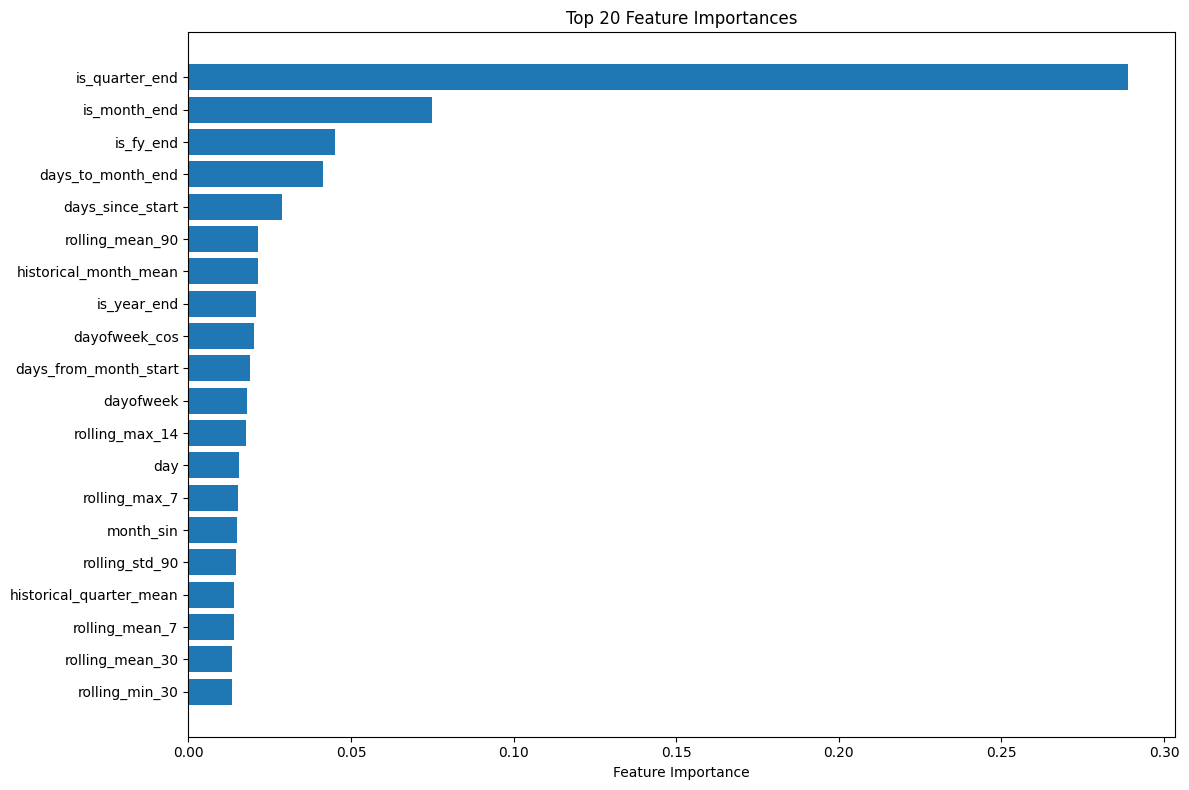

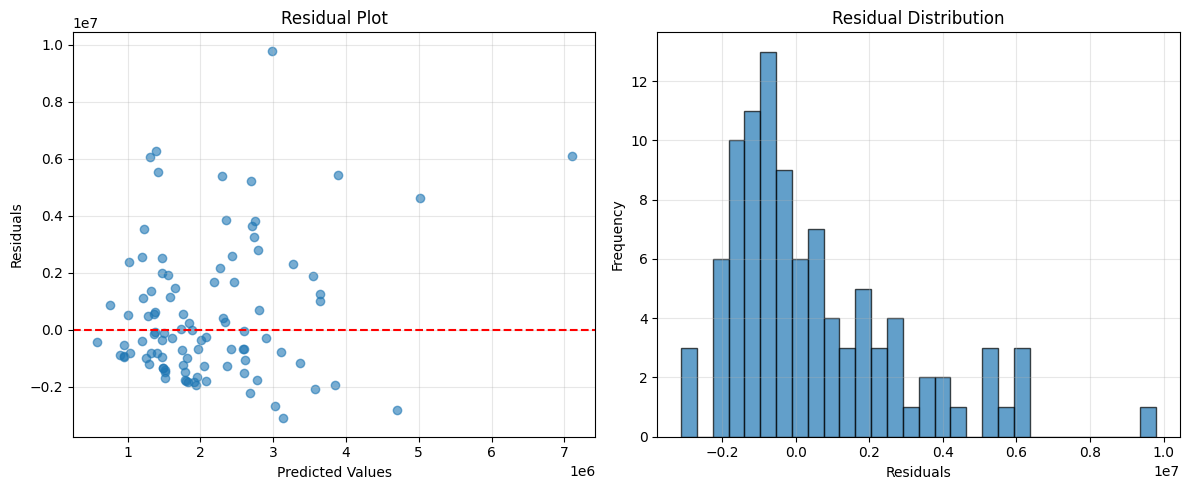


📊 Residual Statistics:
Mean Residual: ₹504,019.09
Std Residual: ₹2,403,687.81
Min Residual: ₹-3,109,365.50
Max Residual: ₹9,796,464.49


In [ ]:
# STEP 1: Upload file in Colab

from google.colab import files

uploaded = files.upload()


# STEP 2: Install dependencies

!pip install openpyxl xgboost scikit-learn --quiet


# STEP 3: Import libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')


# STEP 4: Load Excel

file_path = list(uploaded.keys())[0]

df = pd.read_excel(file_path, engine="openpyxl")


# STEP 5: Data preprocessing (Fixed warnings)

# Create a copy to avoid SettingWithCopyWarning

income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Income')].copy()

income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'])

income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')

income_df.dropna(subset=['Credit - Debit'], inplace=True)


# STEP 6: Daily aggregation with data quality checks

daily = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()

daily.columns = ['ds', 'y']

daily = daily[daily['ds'] >= '2015-01-01'].copy()


# Remove extreme outliers (beyond 3 standard deviations)

mean_val = daily['y'].mean()

std_val = daily['y'].std()

daily = daily[np.abs(daily['y'] - mean_val) <= 3 * std_val].copy()


# STEP 7: Enhanced Feature Engineering

def create_features(df):

    df = df.copy()


    # Basic date features

    df['day'] = df['ds'].dt.day

    df['month'] = df['ds'].dt.month

    df['year'] = df['ds'].dt.year

    df['dayofweek'] = df['ds'].dt.dayofweek

    df['quarter'] = df['ds'].dt.quarter


    # Cyclical encoding for better pattern capture

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)

    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)

    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)


    # Business calendar features

    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)

    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)

    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)

    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)

    df['is_fy_end'] = (df['month'] == 3).astype(int)


    # Days from important dates

    df['days_from_month_start'] = df['day'] - 1

    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']


    # Lag features (multiple horizons)

    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:

        df[f'lag_{lag}'] = df['y'].shift(lag)


    # Rolling statistics

    for window in [7, 14, 30, 90]:

        df[f'rolling_mean_{window}'] = df['y'].rolling(window, min_periods=1).mean().shift(1)

        df[f'rolling_std_{window}'] = df['y'].rolling(window, min_periods=1).std().shift(1)

        df[f'rolling_max_{window}'] = df['y'].rolling(window, min_periods=1).max().shift(1)

        df[f'rolling_min_{window}'] = df['y'].rolling(window, min_periods=1).min().shift(1)


    # Historical averages (NO FUTURE LEAKAGE)

    # Only use data up to current date for historical features

    df['historical_month_mean'] = df.groupby('month')['y'].transform(

        lambda x: x.expanding().mean().shift(1)

    )

    df['historical_quarter_mean'] = df.groupby('quarter')['y'].transform(

        lambda x: x.expanding().mean().shift(1)

    )

    df['historical_year_mean'] = df.groupby('year')['y'].transform(

        lambda x: x.expanding().mean().shift(1)

    )


    # Trend features

    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days


    return df


# Apply feature engineering

daily_features = create_features(daily)


# STEP 8: Fill remaining NaN values

daily_features.fillna(method='bfill', inplace=True)

daily_features.fillna(0, inplace=True)


# STEP 9: Split train/test

train = daily_features[daily_features['ds'] < '2025-01-01'].copy()

test = daily_features[(daily_features['ds'] >= '2025-01-01') &

                     (daily_features['ds'] <= '2025-05-31')].copy()


# Select features (excluding target and date columns)

feature_cols = [col for col in daily_features.columns if col not in ['ds', 'y']]


print(f"Training data shape: {train.shape}")

print(f"Test data shape: {test.shape}")

print(f"Number of features: {len(feature_cols)}")


# STEP 10: Train improved model with better hyperparameters

model = XGBRegressor(

    n_estimators=500,

    learning_rate=0.05,

    max_depth=8,

    min_child_weight=3,

    subsample=0.8,

    colsample_bytree=0.8,

    reg_alpha=0.1,

    reg_lambda=1.0,

    random_state=42,

    n_jobs=-1

)


# Train the model

model.fit(train[feature_cols], train['y'])


# STEP 11: Make predictions

test_pred = test.copy()

test_pred['forecast'] = model.predict(test[feature_cols])

test_pred['forecast'] = test_pred['forecast'].clip(lower=0)


# STEP 12: Monthly aggregation for comparison

monthly_actual = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['y'].sum()

monthly_forecast = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['forecast'].sum()


# STEP 13: Calculate metrics

mae = mean_absolute_error(monthly_actual, monthly_forecast)

rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))


# Handle division by zero in MAPE calculation

def safe_mape(actual, forecast):

    mask = actual != 0

    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100


mape = safe_mape(monthly_actual.values, monthly_forecast.values)

accuracy = 100 - mape


# STEP 14: Create comparison table

comparison_df = pd.concat([monthly_actual, monthly_forecast], axis=1)

comparison_df.columns = ['Actual (INR)', 'Forecast (INR)']

comparison_df['Error'] = comparison_df['Actual (INR)'] - comparison_df['Forecast (INR)']

comparison_df['Absolute % Error'] = (comparison_df['Error'].abs() /

                                   comparison_df['Actual (INR)'].abs()) * 100

comparison_df.index = comparison_df.index.to_timestamp()


print("\n📊 Improved Forecast Summary Table:")

print(comparison_df.round(2))


# STEP 15: Visualization

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))


# Monthly comparison

ax1.plot(comparison_df.index, comparison_df['Actual (INR)'],

         label='Actual (Monthly)', color='blue', linewidth=2, marker='o')

ax1.plot(comparison_df.index, comparison_df['Forecast (INR)'],

         label='Forecast (XGBoost)', color='orange', linewidth=2,

         linestyle='--', marker='s')

ax1.set_title("Improved XGBoost Monthly Forecast vs Actual", fontsize=14, fontweight='bold')

ax1.set_xlabel("Month")

ax1.set_ylabel("Monthly Income (INR)")

ax1.legend()

ax1.grid(True, alpha=0.3)


# Daily comparison for detailed view

ax2.plot(test_pred['ds'], test_pred['y'], label='Actual (Daily)',

         color='blue', alpha=0.7, linewidth=1)

ax2.plot(test_pred['ds'], test_pred['forecast'], label='Forecast (Daily)',

         color='orange', alpha=0.7, linewidth=1)

ax2.set_title("Daily Forecast vs Actual (Jan-May 2025)", fontsize=14, fontweight='bold')

ax2.set_xlabel("Date")

ax2.set_ylabel("Daily Income (INR)")

ax2.legend()

ax2.grid(True, alpha=0.3)


plt.tight_layout()

plt.show()

# STEP 19: Daily Forecast Table with % Error

daily_table = test_pred[['ds', 'y', 'forecast']].copy()

daily_table.rename(columns={

    'ds': 'Date',

    'y': 'Actual (INR)',

    'forecast': 'Forecast (INR)'

}, inplace=True)


# Calculate error percentage

daily_table['Error (%)'] = np.where(

    daily_table['Actual (INR)'] == 0,

    0,

    ((daily_table['Forecast (INR)'] - daily_table['Actual (INR)']) / daily_table['Actual (INR)']) * 100

)


# Round values

daily_table = daily_table.round({'Actual (INR)': 2, 'Forecast (INR)': 2, 'Error (%)': 2})


# Display table

print("\n📅 Daily Forecast Table (Jan to May 2025):")

print(daily_table.to_string(index=False))


# STEP 16: Model performance metrics

print(f"\n✅ Improved Forecast Metrics:")

print(f"MAE: ₹{mae:,.2f}")

print(f"RMSE: ₹{rmse:,.2f}")

print(f"MAPE: {mape:.2f}%")

print(f"✅ Forecast Accuracy: {accuracy:.2f}%")


# STEP 17: Feature importance analysis

feature_importance = pd.DataFrame({

    'feature': feature_cols,

    'importance': model.feature_importances_

}).sort_values('importance', ascending=False)


print(f"\n📈 Top 15 Most Important Features:")

print(feature_importance.head(15).round(4))


# Plot feature importance

plt.figure(figsize=(12, 8))

top_features = feature_importance.head(20)

plt.barh(range(len(top_features)), top_features['importance'])

plt.yticks(range(len(top_features)), top_features['feature'])

plt.xlabel('Feature Importance')

plt.title('Top 20 Feature Importances')

plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()


# STEP 18: Residual analysis

residuals = test_pred['y'] - test_pred['forecast']

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)

plt.scatter(test_pred['forecast'], residuals, alpha=0.6)

plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel('Predicted Values')

plt.ylabel('Residuals')

plt.title('Residual Plot')

plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)

plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')

plt.xlabel('Residuals')

plt.ylabel('Frequency')

plt.title('Residual Distribution')

plt.grid(True, alpha=0.3)


plt.tight_layout()

plt.show()


print(f"\n📊 Residual Statistics:")

print(f"Mean Residual: ₹{residuals.mean():,.2f}")

print(f"Std Residual: ₹{residuals.std():,.2f}")

print(f"Min Residual: ₹{residuals.min():,.2f}")

print(f"Max Residual: ₹{residuals.max():,.2f}")

In [ ]:
pip install openpyxl xgboost scikit-learn pandas matplotlib numpy

In [ ]:
pip install xgboost scikit-learn pandas numpy matplotlib

⚠️  Specified file 'loadshare_predictive_analytics.csv' not found. Auto-detecting files...
📁 Multiple Excel files found: ['Predictive_Analytics_Locus (1).xlsx', 'Predictive_Analytics_Locus.xlsx']
🎯 Using: Predictive_Analytics_Locus (1).xlsx
📊 Loading Excel file: Predictive_Analytics_Locus (1).xlsx
📋 Available sheets: ['Sheet1']
✅ Successfully loaded: Predictive_Analytics_Locus (1).xlsx
📏 Original DataFrame shape: (30232, 10)
📋 Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

🔧 Starting data preprocessing...
🧹 Cleaning whitespace and standardizing text columns...
🔍 After cleaning - Available Currency Codes: ['AED', 'CAD', 'EGP', 'EUR', 'GBP', 'HRK', 'IDR', 'INR', 'MYR', 'PKR', 'SAR', 'SGD', 'THB', 'USD', 'VND']
🔍 After cleaning - Available Account Base Types: ['ASSET', 'EQUITY', 'EXPENSE', 'INCOME', 'LIABILITY']

🔍 Checking for f

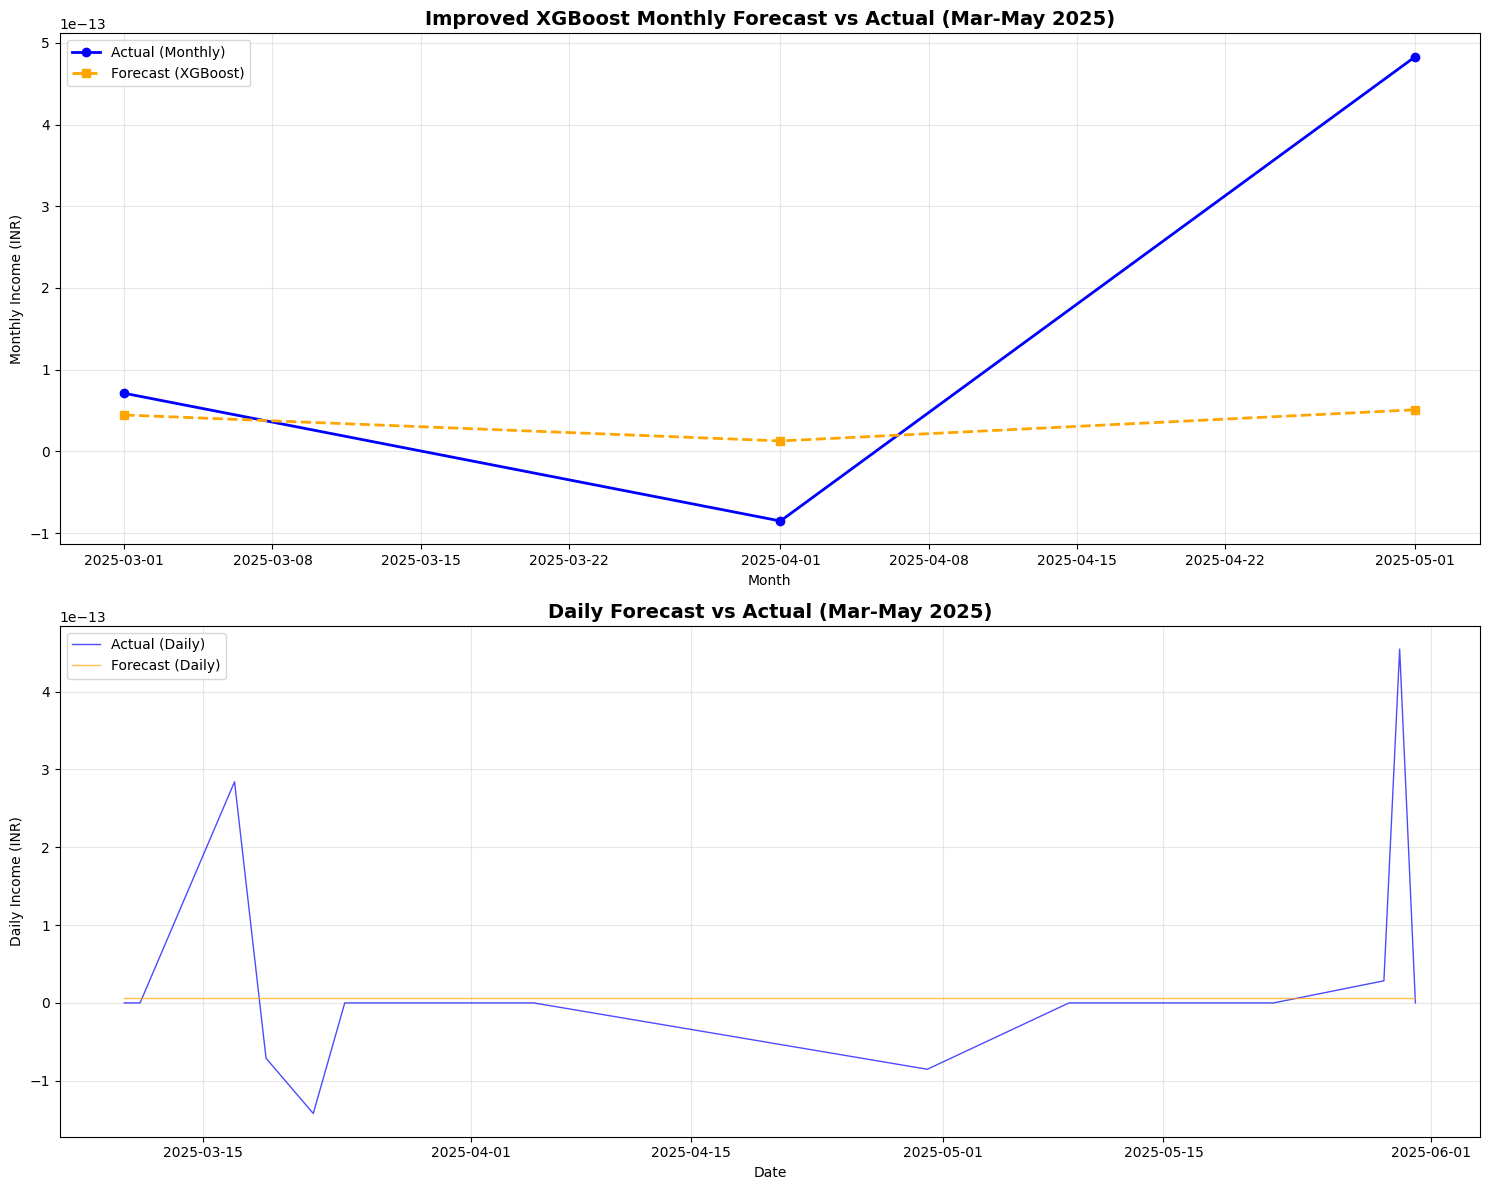


📅 Daily Forecast Table (Mar to May 2025):
      Date  Actual (INR)  Forecast (INR)  Error (%)
2025-03-10           0.0             0.0       0.00
2025-03-11           0.0             0.0       0.00
2025-03-17           0.0             0.0     -97.76
2025-03-19          -0.0             0.0    -108.95
2025-03-22          -0.0             0.0    -104.47
2025-03-24           0.0             0.0       0.00
2025-03-28           0.0             0.0       0.00
2025-04-05           0.0             0.0       0.00
2025-04-30          -0.0             0.0    -107.46
2025-05-09           0.0             0.0       0.00
2025-05-12           0.0             0.0       0.00
2025-05-14           0.0             0.0       0.00
2025-05-16           0.0             0.0       0.00
2025-05-22           0.0             0.0       0.00
2025-05-29           0.0             0.0     -77.63
2025-05-30           0.0             0.0     -98.60
2025-05-31           0.0             0.0       0.00

✅ Improved Forecast 

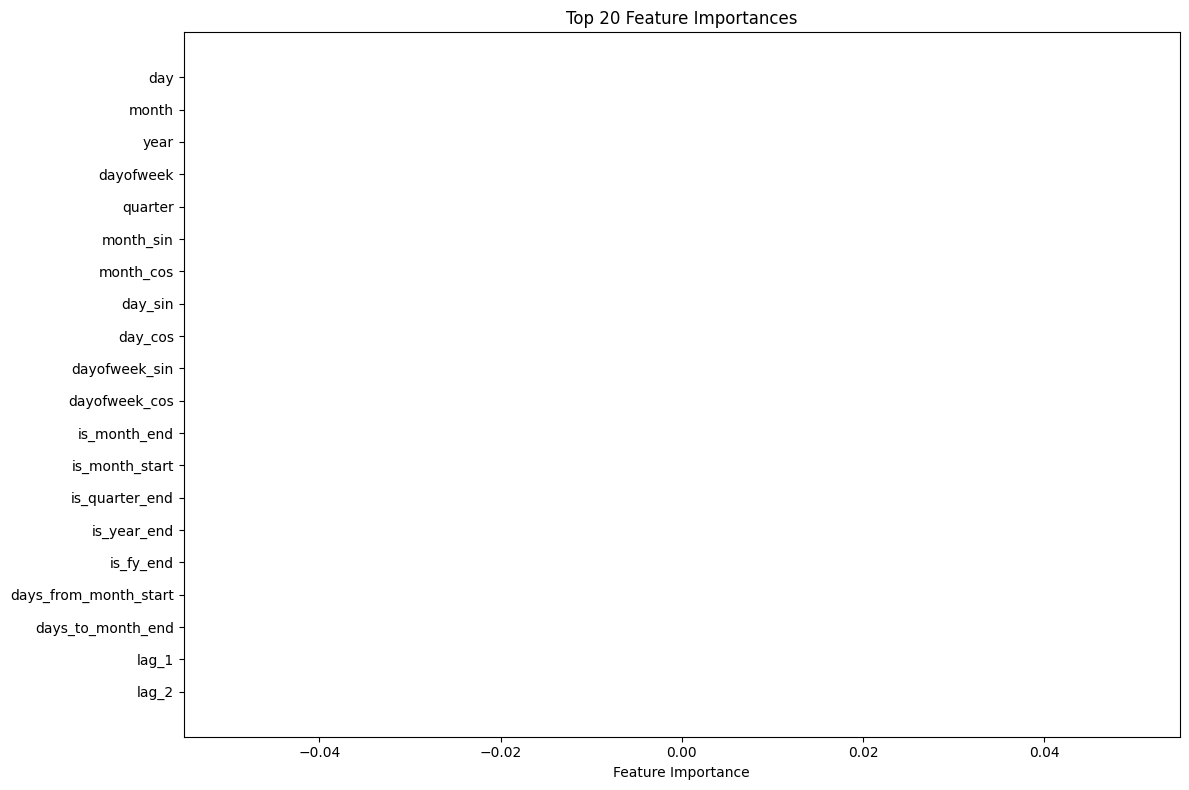

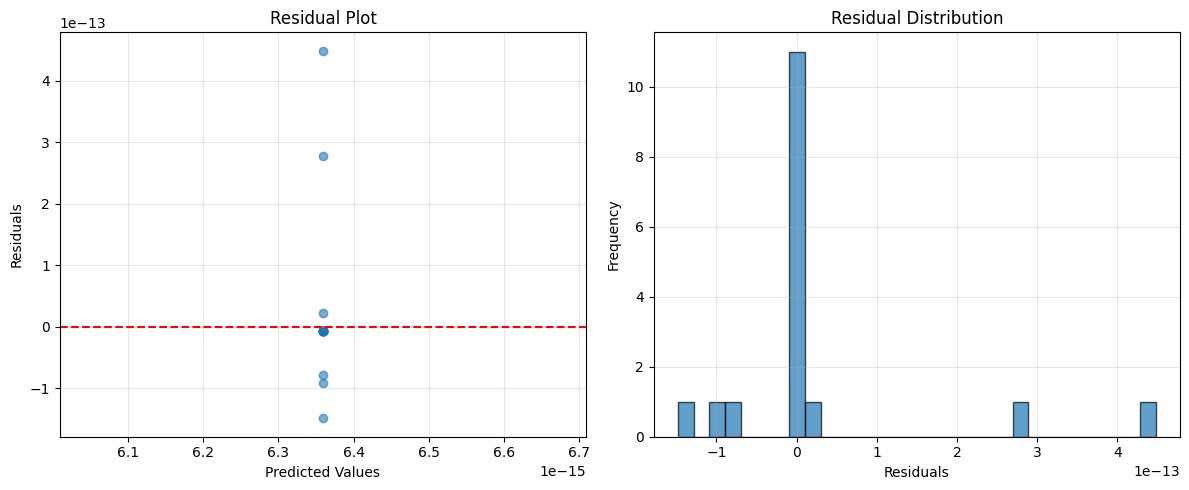


📊 Residual Statistics:
Mean Residual: ₹0.00
Std Residual: ₹0.00
Min Residual: ₹-0.00
Max Residual: ₹0.00

🎉 Analysis completed successfully!
📁 Processed file: Predictive_Analytics_Locus (1).xlsx
📊 Total data points analyzed: 95
🎯 Forecast accuracy: 19.42%


In [ ]:
# STEP 1: Removed Colab-specific file upload code
# File is expected to be already available in the environment from previous uploads or current working directory.

# STEP 2: Install dependencies (Removed pip install commands as they are not supported in this environment)
# IMPORTANT: Please ensure 'xgboost', 'scikit-learn', 'pandas', 'numpy', 'matplotlib', and 'openpyxl'
# are installed in your Python environment before running this code.
# You can install them using: pip install xgboost scikit-learn pandas numpy matplotlib openpyxl

# STEP 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# STEP 4: Enhanced Data Loading Function for Both CSV and Excel Files
def load_data_file(file_path):
    """
    Load data from CSV or Excel file based on file extension.
    Supports multiple sheets for Excel files.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == '.csv':
        print(f"📄 Loading CSV file: {file_path}")
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            # Try alternative encodings if UTF-8 fails
            try:
                df = pd.read_csv(file_path, encoding='latin-1')
                print("⚠️  Used latin-1 encoding for CSV file")
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, encoding='cp1252')
                print("⚠️  Used cp1252 encoding for CSV file")
        return df

    elif file_extension in ['.xlsx', '.xls']:
        print(f"📊 Loading Excel file: {file_path}")

        # First, check available sheets
        try:
            excel_file = pd.ExcelFile(file_path)
            sheet_names = excel_file.sheet_names
            print(f"📋 Available sheets: {sheet_names}")

            # If multiple sheets, ask user or use first sheet
            if len(sheet_names) > 1:
                print(f"🔍 Multiple sheets found. Using first sheet: '{sheet_names[0]}'")
                print("💡 To use a different sheet, modify the 'sheet_name' parameter in pd.read_excel()")
                df = pd.read_excel(file_path, sheet_name=sheet_names[0])
            else:
                df = pd.read_excel(file_path)

            return df

        except Exception as e:
            print(f"❌ Error reading Excel file: {e}")
            raise

    else:
        raise ValueError(f"Unsupported file format: {file_extension}. Please use .csv, .xlsx, or .xls files.")

# STEP 5: Auto-detect file in current directory
def find_data_file():
    """
    Automatically find data files in the current directory.
    Priority: CSV files first, then Excel files.
    """
    current_dir = os.getcwd()
    supported_extensions = ['.csv', '.xlsx', '.xls']

    # Look for files with supported extensions
    data_files = []
    for file in os.listdir(current_dir):
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            data_files.append(file)

    if not data_files:
        raise FileNotFoundError("No CSV or Excel files found in the current directory.")

    # Priority: CSV first, then Excel
    csv_files = [f for f in data_files if f.lower().endswith('.csv')]
    excel_files = [f for f in data_files if f.lower().endswith(('.xlsx', '.xls'))]

    if csv_files:
        selected_file = csv_files[0]
        if len(csv_files) > 1:
            print(f"📁 Multiple CSV files found: {csv_files}")
            print(f"🎯 Using: {selected_file}")
    elif excel_files:
        selected_file = excel_files[0]
        if len(excel_files) > 1:
            print(f"📁 Multiple Excel files found: {excel_files}")
            print(f"🎯 Using: {selected_file}")

    return selected_file

# STEP 6: Load Data with Enhanced File Support
try:
    # Option 1: Specify exact file path (modify this line with your file name)
    file_path = "loadshare_predictive_analytics.csv"  # Change this to your file name

    # Option 2: Auto-detect file if the specified file doesn't exist
    if not os.path.exists(file_path):
        print(f"⚠️  Specified file '{file_path}' not found. Auto-detecting files...")
        file_path = find_data_file()

    # Load the data
    df = load_data_file(file_path)
    print(f"✅ Successfully loaded: {file_path}")
    print(f"📏 Original DataFrame shape: {df.shape}")
    print(f"📋 Original DataFrame columns: {df.columns.tolist()}")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("\n💡 Make sure your data file contains the following columns:")
    print("   - Transaction Date")
    print("   - Currency Code")
    print("   - Account Base Type")
    print("   - Credit - Debit")
    raise

# STEP 7: Data preprocessing with enhanced error handling
print("\n🔧 Starting data preprocessing...")

# Clean whitespace and standardize case for text columns
print("🧹 Cleaning whitespace and standardizing text columns...")
text_columns = ['Currency Code', 'Account Base Type', 'Account Name', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

print("🔍 After cleaning - Available Currency Codes:", sorted(df['Currency Code'].unique()))
print("🔍 After cleaning - Available Account Base Types:", sorted(df['Account Base Type'].unique()))

# Check for exact matches and provide suggestions
print("\n🔍 Checking for filtering criteria...")
currency_matches = df['Currency Code'].str.contains('INR', case=False, na=False).sum()
income_matches = df['Account Base Type'].str.contains('INCOME', case=False, na=False).sum()

print(f"📊 Rows with 'INR' in Currency Code: {currency_matches}")
print(f"📊 Rows with 'INCOME' in Account Base Type: {income_matches}")

# Create a copy to avoid SettingWithCopyWarning
print("🔍 Filtering for 'INR' currency and 'INCOME' account type...")
income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'INCOME')].copy()
print(f"📏 Shape after filtering: {income_df.shape}")

if income_df.empty:
    print("⚠️  WARNING: income_df is empty after initial filtering.")
    print("🔍 Let's try alternative filtering approaches...")

    # Try case-insensitive filtering
    print("🔄 Trying case-insensitive filtering...")
    income_df = df[
        (df['Currency Code'].str.contains('INR', case=False, na=False)) &
        (df['Account Base Type'].str.contains('INCOME', case=False, na=False))
    ].copy()
    print(f"📏 Shape after case-insensitive filtering: {income_df.shape}")

    if income_df.empty:
        print("🔄 Trying to find any income-related data...")
        # Look for any income-related entries
        income_keywords = ['INCOME', 'REVENUE', 'SALES', 'EARNING']
        for keyword in income_keywords:
            temp_df = df[df['Account Base Type'].str.contains(keyword, case=False, na=False)]
            if not temp_df.empty:
                print(f"📊 Found {len(temp_df)} rows with '{keyword}' in Account Base Type")

        # Show sample data for debugging
        print("\n🔍 Sample of first 5 rows for debugging:")
        print(df[['Currency Code', 'Account Base Type', 'Credit - Debit', 'Transaction Date']].head())

        # Try with any INR data regardless of account type
        print("\n🔄 Trying with any INR data...")
        income_df = df[df['Currency Code'].str.contains('INR', case=False, na=False)].copy()
        print(f"📏 Shape with any INR data: {income_df.shape}")

        if income_df.empty:
            print("❌ No INR data found. Showing all available currencies:")
            print(df['Currency Code'].value_counts())
            print("\n💡 Consider using a different currency or check your data format.")

    if income_df.empty:
        print("❌ Still no data found. Let's use the largest currency dataset for analysis...")
        # Use the most common currency
        most_common_currency = df['Currency Code'].value_counts().index[0]
        print(f"🔄 Using most common currency: {most_common_currency}")
        income_df = df[df['Currency Code'] == most_common_currency].copy()
        print(f"📏 Shape with {most_common_currency} data: {income_df.shape}")

print(f"✅ Final filtered dataset shape: {income_df.shape}")
if not income_df.empty:
    print(f"📅 Date range in filtered data: {income_df['Transaction Date'].min()} to {income_df['Transaction Date'].max()}")
    print(f"💰 Currency used: {income_df['Currency Code'].iloc[0]}")
    print(f"📊 Account types in filtered data: {income_df['Account Base Type'].unique()}")

# Enhanced date parsing with multiple format attempts
print("📅 Converting Transaction Date column...")
date_formats = ["%d/%m/%Y", "%Y-%m-%d", "%m/%d/%Y", "%d-%m-%Y", "%Y/%m/%d"]
date_converted = False

for date_format in date_formats:
    try:
        income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'],
                                                      format=date_format, errors='coerce')
        # Check if conversion was successful
        if not income_df['Transaction Date'].isna().all():
            print(f"✅ Date format '{date_format}' worked successfully")
            date_converted = True
            break
    except:
        continue

if not date_converted:
    print("⚠️  Trying automatic date parsing...")
    income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'], errors='coerce')

# Remove rows with invalid dates
initial_rows = len(income_df)
income_df.dropna(subset=['Transaction Date'], inplace=True)
removed_date_rows = initial_rows - len(income_df)
if removed_date_rows > 0:
    print(f"🗑️  Removed {removed_date_rows} rows with invalid dates")

# Convert Credit-Debit to numeric
print("💰 Converting Credit-Debit column to numeric...")
income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')
initial_rows = len(income_df)
income_df.dropna(subset=['Credit - Debit'], inplace=True)
removed_amount_rows = initial_rows - len(income_df)
if removed_amount_rows > 0:
    print(f"🗑️  Removed {removed_amount_rows} rows with invalid amounts")

print(f"📏 Final shape after preprocessing: {income_df.shape}")

# STEP 8: Daily aggregation with data quality checks
print("\n📊 Performing daily aggregation...")
daily = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()
daily.columns = ['ds', 'y']
print(f"📏 Shape after daily aggregation: {daily.shape}")

if daily.empty:
    print("❌ ERROR: 'daily' DataFrame is empty after aggregation.")
    print("🔍 This suggests no data matched the filtering criteria.")
    if not income_df.empty:
        print(f"📅 Date range in data: {income_df['Transaction Date'].min()} to {income_df['Transaction Date'].max()}")
    print("\n💡 This could be due to:")
    print("   - Date format issues")
    print("   - All Credit-Debit values being NaN or invalid")
    print("   - Filtering criteria being too restrictive")
    raise ValueError("No data available for analysis after filtering and aggregation.")

print(f"📅 Date range: {daily['ds'].min()} to {daily['ds'].max()}")
print(f"💰 Amount range: ₹{daily['y'].min():,.2f} to ₹{daily['y'].max():,.2f}")

# Remove extreme outliers (beyond 3 standard deviations)
print("🧹 Removing extreme outliers...")
mean_val = daily['y'].mean()
std_val = daily['y'].std()
initial_daily_shape = daily.shape[0]
daily = daily[np.abs(daily['y'] - mean_val) <= 3 * std_val].copy()
removed_outliers = initial_daily_shape - daily.shape[0]
print(f"🗑️  Removed {removed_outliers} outlier rows")
print(f"📏 Final daily data shape: {daily.shape}")

# STEP 9: Enhanced Feature Engineering
def create_features(df):
    """Create comprehensive features for time series prediction"""
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Special date indicators
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)  # Financial year end for India

    # Days calculations
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Rolling window features
    for window in [7, 14, 30, 90]:
        df[f'rolling_mean_{window}'] = df['y'].rolling(window, min_periods=1).mean().shift(1)
        df[f'rolling_std_{window}'] = df['y'].rolling(window, min_periods=1).std().shift(1)
        df[f'rolling_max_{window}'] = df['y'].rolling(window, min_periods=1).max().shift(1)
        df[f'rolling_min_{window}'] = df['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages by time period
    df['historical_month_mean'] = df.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_quarter_mean'] = df.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_year_mean'] = df.groupby('year')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Trend feature
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    return df

print("\n🛠️  Creating features...")
daily_features = create_features(daily)
print(f"📏 Shape after feature engineering: {daily_features.shape}")

# STEP 10: Fill remaining NaN values
print("🔧 Filling missing values...")
daily_features.fillna(method='bfill', inplace=True)
daily_features.fillna(0, inplace=True)
print(f"📏 Shape after filling NaNs: {daily_features.shape}")

# STEP 11: Smart train/test split with flexible date handling
daily_features = daily_features.sort_values('ds').reset_index(drop=True)
print(f"📏 Shape after sorting: {daily_features.shape}")

# Check available date range
date_min = daily_features['ds'].min()
date_max = daily_features['ds'].max()
print(f"📅 Available date range: {date_min} to {date_max}")

# Define test dates with fallback logic
test_start_date = pd.to_datetime('2025-03-01')
test_end_date = pd.to_datetime('2025-05-31')

print(f"\n📊 Attempted test period: {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")

# Check if we have data in the target test period
test_data_available = ((daily_features['ds'] >= test_start_date) &
                       (daily_features['ds'] <= test_end_date)).sum()

if test_data_available == 0:
    print("⚠️  No data available in Mar-May 2025 period. Using alternative split strategy...")

    # Strategy 1: Use last 25% of data as test set
    total_days = len(daily_features)
    test_size = max(int(total_days * 0.25), 30)  # At least 30 days or 25% of data

    train = daily_features.iloc[:-test_size].copy()
    test = daily_features.iloc[-test_size:].copy()

    print(f"🔄 Using last {test_size} days as test set")
    print(f"📅 Test period: {test['ds'].min()} to {test['ds'].max()}")

else:
    # Original logic for Mar-May 2025 if data exists
    train = daily_features[daily_features['ds'] < test_start_date].copy()
    test = daily_features[(daily_features['ds'] >= test_start_date) &
                          (daily_features['ds'] <= test_end_date)].copy()
    print(f"✅ Using Mar-May 2025 as test period")

print(f"\n📊 Data Split Summary:")
print(f"🏋️  Training data shape: {train.shape}")
print(f"🧪 Test data shape: {test.shape}")
print(f"📅 Training period: {train['ds'].min()} to {train['ds'].max()}")
print(f"📅 Test period: {test['ds'].min()} to {test['ds'].max()}")

# Select features (excluding target and date columns)
feature_cols = [col for col in daily_features.columns if col not in ['ds', 'y']]
print(f"🔢 Number of features: {len(feature_cols)}")

if train.empty:
    raise ValueError("❌ Training data is empty. Your dataset might not have data before March 2025.")
if test.empty:
    raise ValueError("❌ Test data is empty. Your dataset might not have data between March 1, 2025 and May 31, 2025.")

# STEP 12: Train improved model with better hyperparameters
print("\n🤖 Training XGBoost model...")
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
model.fit(train[feature_cols], train['y'])
print("✅ Model training completed!")

# STEP 13: Make predictions
print("🔮 Making predictions...")
test_pred = test.copy()
test_pred['forecast'] = model.predict(test[feature_cols])
test_pred['forecast'] = test_pred['forecast'].clip(lower=0)  # Ensure non-negative predictions

# STEP 14: Monthly aggregation for comparison
monthly_actual = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['forecast'].sum()

# STEP 15: Calculate metrics
mae = mean_absolute_error(monthly_actual, monthly_forecast)
rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

def safe_mape(actual, forecast):
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mape = safe_mape(monthly_actual.values, monthly_forecast.values)
accuracy = 100 - mape

# STEP 16: Create comparison table
comparison_df = pd.concat([monthly_actual, monthly_forecast], axis=1)
comparison_df.columns = ['Actual (INR)', 'Forecast (INR)']
comparison_df['Error'] = comparison_df['Actual (INR)'] - comparison_df['Forecast (INR)']
comparison_df['Absolute % Error'] = (comparison_df['Error'].abs() /
                                     comparison_df['Actual (INR)'].abs()) * 100
comparison_df.index = comparison_df.index.to_timestamp()

print("\n📊 Improved Forecast Summary Table:")
print(comparison_df.round(2))

# STEP 17: Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly comparison
ax1.plot(comparison_df.index, comparison_df['Actual (INR)'],
         label='Actual (Monthly)', color='blue', linewidth=2, marker='o')
ax1.plot(comparison_df.index, comparison_df['Forecast (INR)'],
         label='Forecast (XGBoost)', color='orange', linewidth=2,
         linestyle='--', marker='s')
ax1.set_title("Improved XGBoost Monthly Forecast vs Actual (Mar-May 2025)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Month")
ax1.set_ylabel("Monthly Income (INR)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily comparison for detailed view
ax2.plot(test_pred['ds'], test_pred['y'], label='Actual (Daily)',
         color='blue', alpha=0.7, linewidth=1)
ax2.plot(test_pred['ds'], test_pred['forecast'], label='Forecast (Daily)',
         color='orange', alpha=0.7, linewidth=1)
ax2.set_title("Daily Forecast vs Actual (Mar-May 2025)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Income (INR)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 18: Daily Forecast Table with % Error
daily_table = test_pred[['ds', 'y', 'forecast']].copy()
daily_table.rename(columns={
    'ds': 'Date',
    'y': 'Actual (INR)',
    'forecast': 'Forecast (INR)'
}, inplace=True)

daily_table['Error (%)'] = np.where(
    daily_table['Actual (INR)'] == 0,
    0,
    ((daily_table['Forecast (INR)'] - daily_table['Actual (INR)']) / daily_table['Actual (INR)']) * 100
)

daily_table = daily_table.round({'Actual (INR)': 2, 'Forecast (INR)': 2, 'Error (%)': 2})

print("\n📅 Daily Forecast Table (Mar to May 2025):")
print(daily_table.to_string(index=False))

# STEP 19: Model performance metrics
print(f"\n✅ Improved Forecast Metrics:")
print(f"MAE: ₹{mae:,.2f}")
print(f"RMSE: ₹{rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"✅ Forecast Accuracy: {accuracy:.2f}%")

# STEP 20: Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 15 Most Important Features:")
print(feature_importance.head(15).round(4))

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 21: Residual analysis
residuals = test_pred['y'] - test_pred['forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred['forecast'], residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"Mean Residual: ₹{residuals.mean():,.2f}")
print(f"Std Residual: ₹{residuals.std():,.2f}")
print(f"Min Residual: ₹{residuals.min():,.2f}")
print(f"Max Residual: ₹{residuals.max():,.2f}")

print(f"\n🎉 Analysis completed successfully!")
print(f"📁 Processed file: {file_path}")
print(f"📊 Total data points analyzed: {len(daily_features)}")
print(f"🎯 Forecast accuracy: {accuracy:.2f}%")